## Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,  StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Lasso

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load train and test data
train_df = pd.read_csv("../dsa4263_project/data/train_data.csv")
test_df = pd.read_csv("../dsa4263_project/data/test_data.csv")

In [3]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
scaler_train = StandardScaler()
numeric_cols_train = X_train.select_dtypes(include=['number'])
X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

scaler_test = StandardScaler()
numeric_cols_test = X_test.select_dtypes(include=['number'])
X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

### Undersampling majority class: Random Undersampling

In [5]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


### Oversampling minority class: SMOTE-NC

In [6]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-hot encoding (for random forest)

In [7]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
X_test_ohe = pd.get_dummies(X_test, drop_first = True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 541


### Feature selection

##### SelectKBest

In [8]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_kbest = selector.fit_transform(X_train_ohe,y_train_smote)
X_test_kbest = selector.transform(X_test_ohe)

##### Lasso

In [9]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_ohe, y_train_smote)
feature_importance = pd.Series(lasso.coef_, index=X_train_ohe.columns)
selected_features = feature_importance[feature_importance != 0].index.tolist()
X_train_lasso = X_train_ohe.loc[:, selected_features]
X_test_lasso = X_test_ohe.loc[:, selected_features]

##### RFECV

In [8]:
# Run RFECV with step = 0.1 first to narrow down to a rough figure
cv_split = StratifiedKFold(5, shuffle=True, random_state=123)
model = RandomForestClassifier(random_state=123)

rfecv_estimate = RFECV(
    estimator=model,
    step=0.1,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 1
)

rfecv_estimate.fit(X_train_ohe, y_train_smote)

print(f"Optimal number of features: {rfecv_estimate.n_features_}")

Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 487 features.
Fitting estimator with 487 features.
Fitting estimator with 487 features.
Fitting estimator with 487 features.
Fitting estimator with 487 features.
Fitting estimator with 433 features.
Fitting estimator with 433 features.
Fitting estimator with 433 features.
Fitting estimator with 433 features.
Fitting estimator with 433 features.
Fitting estimator with 379 features.
Fitting estimator with 379 features.
Fitting estimator with 379 features.
Fitting estimator with 379 features.
Fitting estimator with 379 features.
Fitting estimator with 325 features.
Fitting estimator with 325 features.
Fitting estimator with 325 features.
Fitting estimator with 325 features.
Fitting estimator with 325 features.
Fitting estimator with 271 features.
Fitting estimator with 271 features.
F

In [9]:
# Run RFECV again on selected features to further narrow down to more precise number of features

top_features = np.where(rfecv_estimate.support_)[0]
X_rfecv_estimate = X_train_ohe.iloc[:, top_features]

rfecv_fine = RFECV(estimator=model,
    step=5,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 2)
rfecv_fine.fit(X_rfecv_estimate, y_train_smote)

print(f"Optimal number of features: {rfecv_fine.n_features_}")

selected_columns = rfecv_fine.get_feature_names_out()
X_train_rfecv = X_train_ohe[selected_columns]
X_test_rfecv = X_test_ohe[selected_columns]

Fitting estimator with 55 features.
Fitting estimator with 55 features.
Fitting estimator with 55 features.
Fitting estimator with 55 features.
Fitting estimator with 55 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 40 features.
Fitting estimator with 40 features.
Fitting estimator with 40 features.
Fitting estimator with 40 features.
Fitting estimator with 40 features.
Fitting estimator with 35 features.
Fitting estimator with 35 features.
Fitting estimator with 35 features.
Fitting estimator with 35 features.
Fitting estimator with 35 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 fe

In [17]:
# Use this cell to skip waiting for RFECV (~35 minutes)
selected_columns = ['zip', 'city_pop', 'amt', 'hour', 'year', 'age', 'prev_trans_fraud', 'count_fraud_7days', 'acc_fraud_count', 'merchant_prev_trans_fraud', 
                    'merchant_acc_fraud_count', 'transaction_risk_score', 'hourly_risk_score', 'visited_cat', 'city_population_class', 'interval', 'first_second_purchase',
                    'interval_deviation', 'influential_merchant', 'category_gas_transport', 'category_grocery_pos', 'category_kids_pets', 'category_misc_net', 
                    'trans_quarter_2021Q3', 'trans_quarter_2021Q4']
X_train_rfecv = X_train_ohe[selected_columns]
X_test_rfecv = X_test_ohe[selected_columns]

## Base model

accuracy: 0.9960709064327485, precision: 0.9963523929355558, recall: 0.9948053728070176, f1: 0.9955728918197151
AUC: 0.99


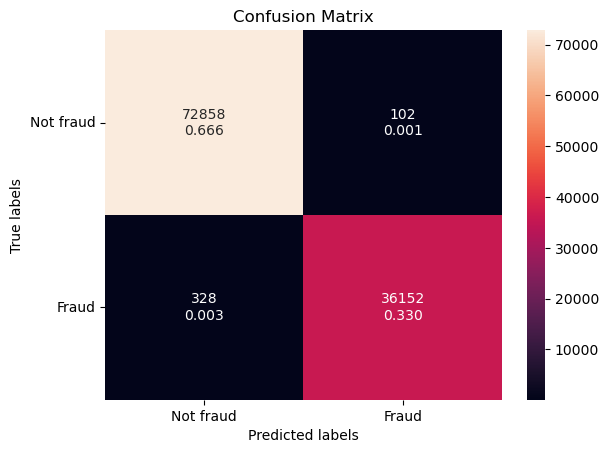

In [24]:
# SelectKBest

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation
y_pred_kbest = cross_val_predict(clf, X_train_kbest, y_train_smote, cv = sk_folds)

# Calculate scores
auc_kbest = roc_auc_score(y_train_smote, y_pred_kbest)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_kbest)}, precision: {precision_score(y_train_smote, y_pred_kbest, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_kbest, average='macro')}, f1: {f1_score(y_train_smote, y_pred_kbest, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_kbest, 2)}')

#Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_kbest)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9964364035087719, precision: 0.9963783438319879, recall: 0.9956003289473685, f1: 0.9959878145297825
AUC: 1.0


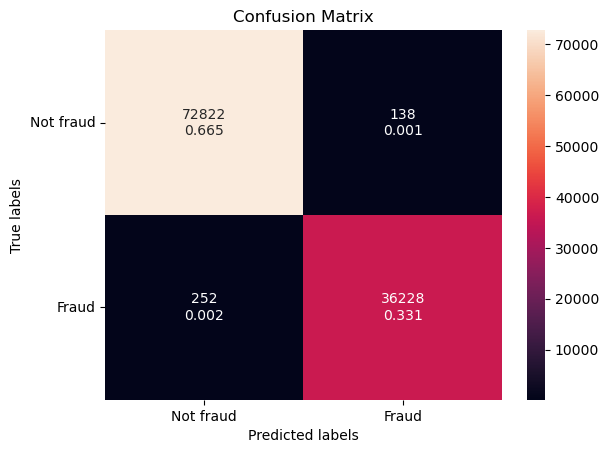

In [23]:
# Lasso

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso = cross_val_predict(clf, X_train_lasso, y_train_smote, cv = sk_folds)

# Run cross validation
auc_lasso = roc_auc_score(y_train_smote, y_pred_lasso)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso)}, precision: {precision_score(y_train_smote, y_pred_lasso, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_lasso, average='macro')}, f1: {f1_score(y_train_smote, y_pred_lasso, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_lasso, 2)}')

# Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_lasso)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9955774853801169, precision: 0.9960811819172555, recall: 0.9939692982456141, f1: 0.9950141026648907
AUC: 0.99


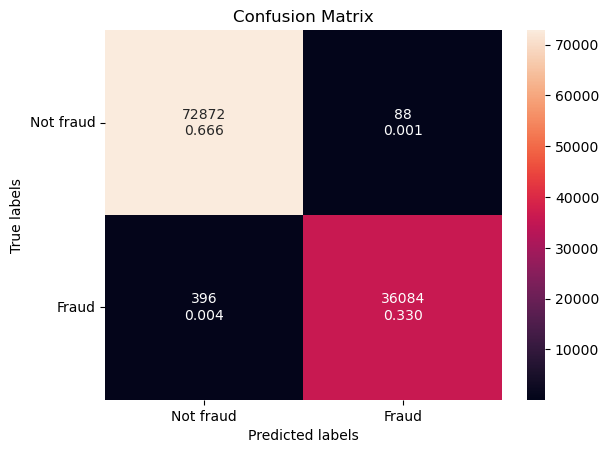

In [22]:
# RFECV

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation
y_pred_rfecv = cross_val_predict(clf, X_train_rfecv, y_train_smote, cv = sk_folds)

# Calculate scores
auc_rfecv = roc_auc_score(y_train_smote, y_pred_rfecv)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_rfecv)}, precision: {precision_score(y_train_smote, y_pred_rfecv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_rfecv, average='macro')}, f1: {f1_score(y_train_smote, y_pred_rfecv, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_rfecv, 2)}')

# Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_rfecv)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

## GridSearchCV RFECV

In [14]:
# Apply GridSearchCV on random forest with RFECV to tune hyperparameters
clf_rfecv = RandomForestClassifier(random_state=123)

params = {'n_estimators': [50, 100, 150], 
         'max_features': ['sqrt', 10, 15],
         'max_depth': [10, 15],
         'criterion': ['gini', 'entropy']}
cv_rfecv = GridSearchCV(estimator = clf_rfecv, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'f1')

cv_rfecv.fit(X_train_rfecv, y_train_smote)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50; total time=  24.1s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50; total time=  24.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50; total time=  24.5s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50; total time=  24.8s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=50; total time=  25.7s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  45.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  46.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  48.2s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  40.2s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time= 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15],
                         'max_features': ['sqrt', 10, 15],
                         'n_estimators': [50, 100, 150]},
             scoring='f1', verbose=2)

In [15]:
# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_rfecv.best_params_}')
cv_best_model_rfecv = cv_rfecv.best_estimator_

# Print top 10 most important features
importance= pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': cv_best_model_rfecv.feature_importances_
})

print('\nTop 10 most important features:')
importance.sort_values(by='Importance', ascending=False)[:10]

Chosen hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 10, 'n_estimators': 50}

Top 10 most important features:


,Feature,Importance
6,prev_trans_fraud,0.534114
13,visited_cat,0.178843
2,amt,0.105664
9,merchant_prev_trans_fraud,0.064305
7,count_fraud_7days,0.042881
3,hour,0.034086
12,hourly_risk_score,0.014027
8,acc_fraud_count,0.008177
15,interval,0.003906
20,category_grocery_pos,0.001918


accuracy: 0.9986202485380117, precision: 0.9985057366606362, recall: 0.9983895285087719, f1: 0.9984475987049671
AUC: 0.9984


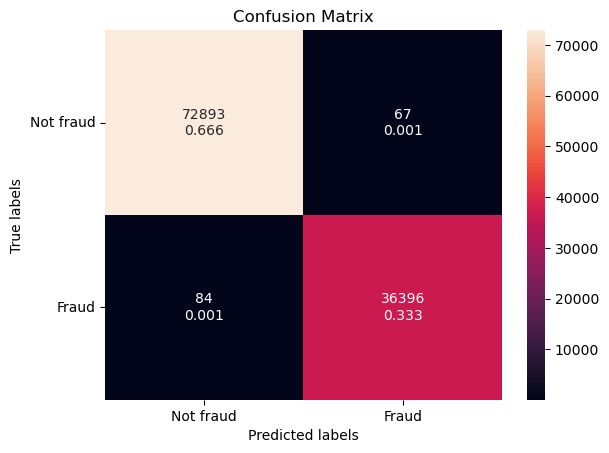

In [16]:
# Initiate stratified k folds
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation with chosen model
y_pred_gscv_rfecv = cross_val_predict(cv_best_model_rfecv, X_train_rfecv, y_train_smote, cv = sk_folds)

# Calculate scores
auc_gscv_rfecv = roc_auc_score(y_train_smote, y_pred_gscv_rfecv)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_gscv_rfecv)}, precision: {precision_score(y_train_smote, y_pred_gscv_rfecv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_gscv_rfecv, average='macro')}, f1: {f1_score(y_train_smote, y_pred_gscv_rfecv, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_gscv_rfecv, 4)}')

# Plot confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_train_smote, y_pred_gscv_rfecv)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

## Run on test data

accuracy: 0.9999984765688674, precision: 0.9999992358105299, recall: 0.9997648165569144, f1: 0.9998819985212986
AUC: 0.9998


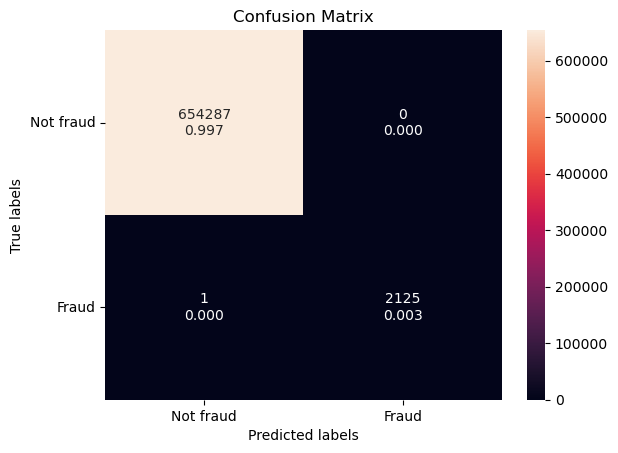

In [32]:
best_model_test = cv_rfecv.best_estimator_
best_model_test.fit(X_test_rfecv, y_test)

y_test_pred = best_model_test.predict(X_test_rfecv)
auc_test = roc_auc_score(y_test, y_test_pred)
print(f"accuracy: {accuracy_score(y_test, y_test_pred)}, precision: {precision_score(y_test, y_test_pred, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_test_pred, average='macro')}, f1: {f1_score(y_test, y_test_pred, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_test, 4)}')

# Plot confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_test, y_test_pred)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

### Feature importance plot


Top 10 most important features:
                      Feature  Importance
6            prev_trans_fraud    0.532300
9   merchant_prev_trans_fraud    0.168857
13                visited_cat    0.137303
12          hourly_risk_score    0.055541
3                        hour    0.041947
8             acc_fraud_count    0.018642
2                         amt    0.015788
7           count_fraud_7days    0.014409
15                   interval    0.006822
22          category_misc_net    0.002595


<Axes: xlabel='Importance', ylabel='Feature'>

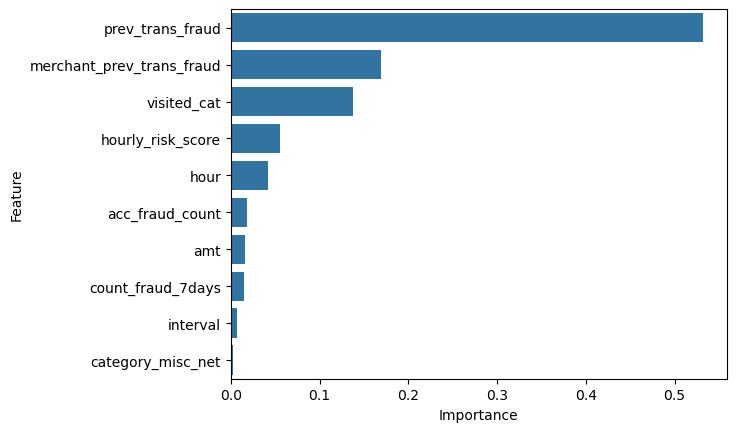

In [17]:
importance= pd.DataFrame({
    'Feature': X_test_rfecv.columns,
    'Importance': best_model_test.feature_importances_
})

print('\nTop 10 most important features:')
print(importance.sort_values(by='Importance', ascending=False)[:10])

sns.barplot(data = importance.sort_values(by='Importance', ascending=False)[:10], x = 'Importance', y = 'Feature')


### SHAP

In [20]:
import shap

In [21]:
explainer = shap.Explainer(best_model_test)
shap_values = explainer.shap_values(X_test_rfecv)

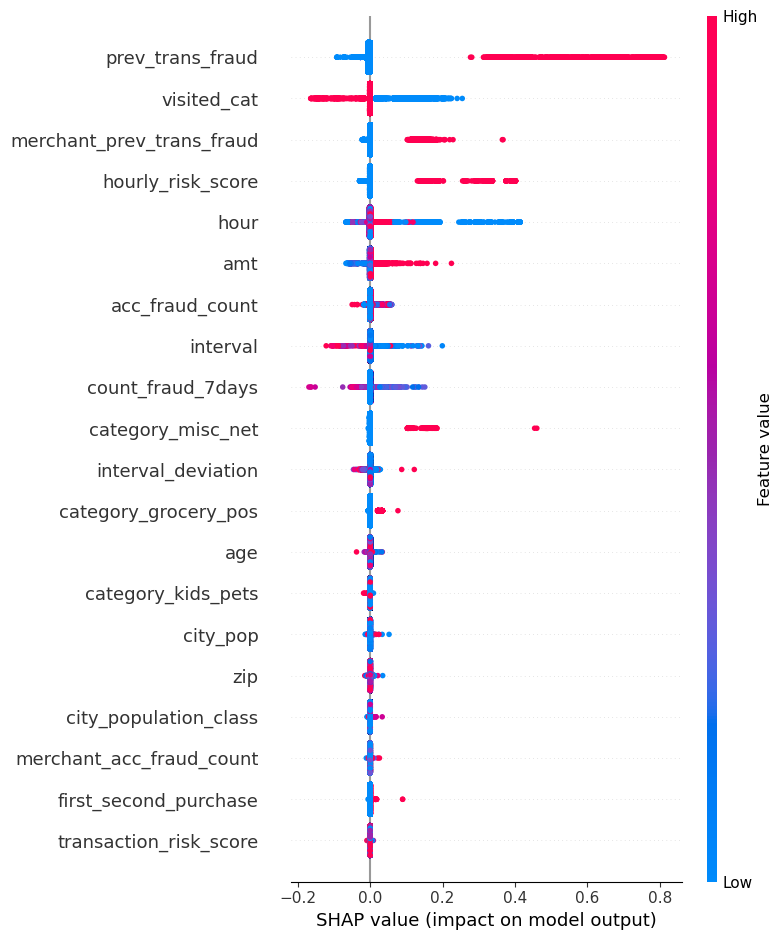

In [22]:
shap.summary_plot(shap_values[:,:, 1], X_test_rfecv)

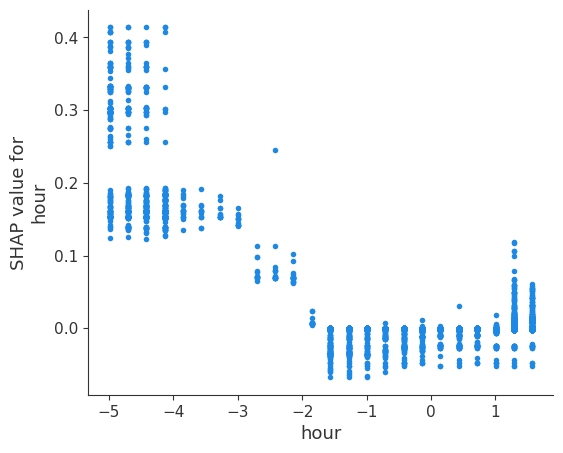

In [23]:
shap.dependence_plot("hour", shap_values[:,:,1], X_test_rfecv,interaction_index=None)

### Local example

Predicted value for row 1 of test data: 1
SHAP plot:


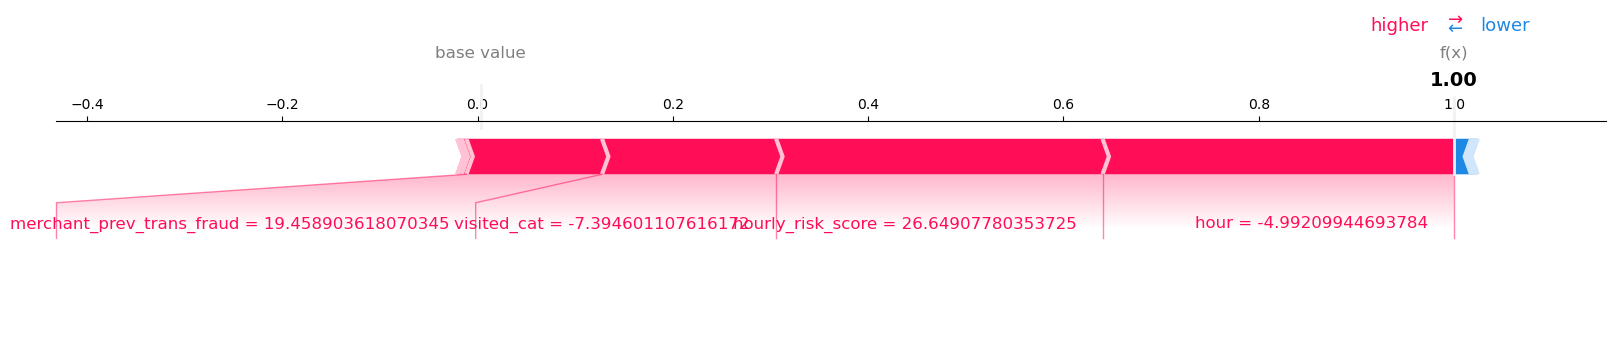

In [24]:
print(f'Predicted value for row 1 of test data: {best_model_test.predict(X_test_rfecv.head(1))[0]}')
print('SHAP plot:')
shap.plots.force(explainer.expected_value[1], shap_values[:, :, 1][0,:], X_test_rfecv.iloc[0, :], matplotlib = True)

It appears that the biggest contributors were `hourly_risk_score`, `hour` and `prev_trans_fraud` 

## Testing a much more simplified version of GridSearchCV

In [29]:
# Apply GridSearchCV on random forest with RFECV to tune hyperparameters
clf_test = RandomForestClassifier(random_state=123)

params = {'n_estimators': [3, 5, 10], 
         'max_features': ['sqrt', 10],
         'max_depth': [3, 5, 10],
         'criterion': ['gini', 'entropy']}
cv_test = GridSearchCV(estimator = clf_test, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'f1')

cv_test.fit(X_train_rfecv, y_train_smote)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=3; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=3; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=3; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=3; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=3; total time=   1.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=5; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=5; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=5; total time=   1.4s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=5; total time=   1.8s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=5; total time=   1.8s
[CV] END criterion

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt', 10],
                         'n_estimators': [3, 5, 10]},
             scoring='f1', verbose=2)

Chosen hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'n_estimators': 10}
accuracy: 0.9979440789473685, precision: 0.9979430168054448, recall: 0.9974300986842105, f1: 0.9976858981904735
AUC: 0.9974


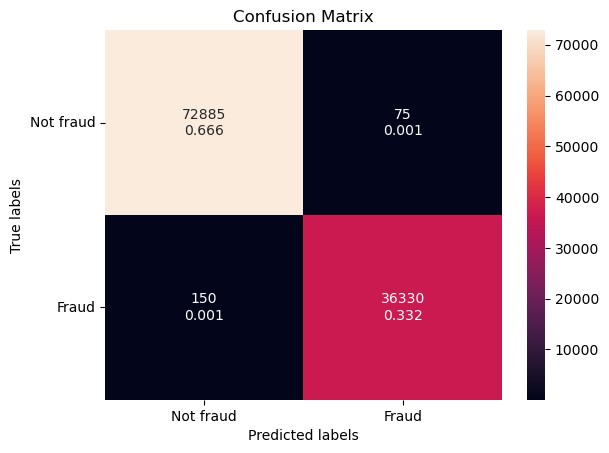

In [30]:
print(f'Chosen hyperparameters: {cv_test.best_params_}')
cv_best_model_test = cv_test.best_estimator_

# Initiate stratified k folds
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation with chosen model
y_pred_gscv_test = cross_val_predict(cv_best_model_test, X_train_rfecv, y_train_smote, cv = sk_folds)

# Calculate scores
auc_gscv_test = roc_auc_score(y_train_smote, y_pred_gscv_test)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_gscv_test)}, precision: {precision_score(y_train_smote, y_pred_gscv_test, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_gscv_test, average='macro')}, f1: {f1_score(y_train_smote, y_pred_gscv_test, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_gscv_test, 4)}')

# Plot confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_train_smote, y_pred_gscv_test)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9999984765688674, precision: 0.9997649271274095, recall: 0.9999992358093619, f1: 0.9998820538319695
AUC: 0.999999235809362


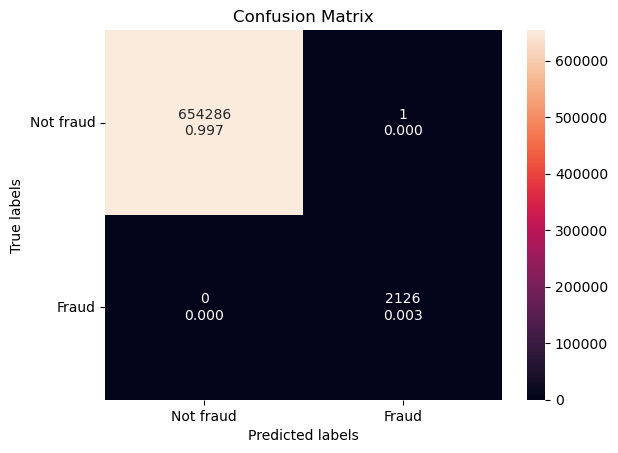

In [31]:
best_model_simple = cv_test.best_estimator_
best_model_simple.fit(X_test_rfecv, y_test)

y_test_pred_simple = best_model_simple.predict(X_test_rfecv)
auc_test_simple = roc_auc_score(y_test, y_test_pred_simple)
print(f"accuracy: {accuracy_score(y_test, y_test_pred_simple)}, precision: {precision_score(y_test, y_test_pred_simple, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_test_pred_simple, average='macro')}, f1: {f1_score(y_test, y_test_pred_simple, average='macro', zero_division = 0.0)}")
print(f'AUC: {auc_test_simple}')

# Plot confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_test, y_test_pred_simple)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()